In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4 as nc

from datetime import datetime, timedelta
from data.base_dataset import AwsBaseDatasetForGdapsKim

In [2]:
# set the font globally
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rcParams.update({'font.size':20})

In [3]:
dataset = AwsBaseDatasetForGdapsKim("/data/nims")

In [4]:
timestamps = []

In [5]:
for year in 2020, 2021:
    ts = datetime(year, 7, 1, 0)
    while ts < datetime(year, 8, 31) + timedelta(hours=87):
        timestamps.append(ts)
        ts = ts + timedelta(hours=1)

In [6]:
len(timestamps)

3102

In [7]:
timestamps[::500]

[datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 7, 21, 20, 0),
 datetime.datetime(2020, 8, 11, 16, 0),
 datetime.datetime(2020, 9, 1, 12, 0),
 datetime.datetime(2021, 7, 19, 17, 0),
 datetime.datetime(2021, 8, 9, 13, 0),
 datetime.datetime(2021, 8, 30, 9, 0)]

In [8]:
timestamps[0], timestamps[-1]

(datetime.datetime(2020, 7, 1, 0, 0), datetime.datetime(2021, 9, 3, 14, 0))

In [9]:
arrays_by_timestamp = dict()
arrays = []
for t in timestamps:
    array = dataset.load_array(t, 0)
    array[array==-9999] = np.nan
    arrays_by_timestamp[t] = array
    arrays.append(array)

# Consistency / Ratio of NaN

In [10]:
full_array = np.stack(arrays)
total_points = full_array.shape[-1] * full_array.shape[-2]
total_timestamps = len(timestamps)
print(full_array.shape, total_points)

(3102, 50, 65) 3250


### Number of nan observations by point

In [11]:
nan_counts_by_point = pd.Series(np.isnan(full_array).sum(axis=0).flatten())

In [12]:
nan_counts_by_point.value_counts().sort_index()

0         31
1          8
2          9
3         10
4          7
        ... 
818        1
1183       1
1558       1
1568       1
3102    2766
Length: 145, dtype: int64

### Distribution of number of nan observations

<AxesSubplot:>

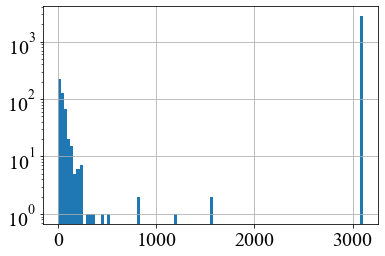

In [13]:
nan_counts_by_point.hist(bins=100, log=True)

In [14]:
valid_nan_counts = nan_counts_by_point[nan_counts_by_point!=total_timestamps]
valid_points = len(valid_nan_counts)
print("Number of points:", total_points)
print("Number of points with at least one valid observation:", valid_points)
print("Ratio of points with at least one valid observation:", valid_points / total_points)

Number of points: 3250
Number of points with at least one valid observation: 484
Ratio of points with at least one valid observation: 0.14892307692307694


### Ratio of non-nan observations (among valid points)

In [15]:
mean_nan = valid_nan_counts.mean()
mean_non_nan = total_timestamps - mean_nan
print("Total timestamps: ", total_timestamps)
print("Mean non-nan observation among valid points: ", mean_non_nan)
print("Ratio of non-nan observations among valid points: ", mean_non_nan / total_timestamps)

Total timestamps:  3102
Mean non-nan observation among valid points:  3041.121900826446
Ratio of non-nan observations among valid points:  0.9803745650633289


# Rain Ratio

### Total

In [16]:
valid_count = (~np.isnan(full_array)).sum()
no_rain_count = (full_array < 0.1).sum()
rain_count = ((full_array < 10) & (full_array >= 0.1)).sum()
heavy_count = (full_array >= 10).sum()
print("Total valid observations:      ", valid_count)
print("Total no-rain observations:    ", no_rain_count)
print("Total rain observations:       ", rain_count)
print("Total heavy observations:      ", heavy_count)

print()

print("Ratio of no-rain observations:    ", no_rain_count / valid_count)
print("Ratio of rain observations:       ", rain_count / valid_count)
print("Ratio of heavy observations:      ", heavy_count / valid_count)

Total valid observations:       1471903
Total no-rain observations:     1284159
Total rain observations:        170240
Total heavy observations:       17504

Ratio of no-rain observations:     0.8724481164859369
Ratio of rain observations:        0.1156597955164165
Ratio of heavy observations:       0.011892087997646584


## Temporal

In [17]:
stats_by_time = defaultdict(list)
for ts, a in arrays_by_timestamp.items():
    valid_count = (~np.isnan(a)).sum()
    no_rain_count = (a < 0.1).sum()
    rain_count = ((a < 10) & (a >= 0.1)).sum()
    heavy_count = (a >= 10).sum()
    
    stats_by_time["date"].append(ts - timedelta(hours=ts.hour))
    stats_by_time["hour"].append(ts.hour)
    
    stats_by_time["valid"].append(valid_count)
    stats_by_time["no_rain"].append(no_rain_count)
    stats_by_time["rain"].append(rain_count)
    stats_by_time["heavy"].append(heavy_count)
    
stats_by_time = pd.DataFrame(stats_by_time)

In [18]:
stats_by_time

,date,hour,valid,no_rain,rain,heavy
0,2020-07-01,0,471,437,34,0
1,2020-07-01,1,470,443,27,0
2,2020-07-01,2,467,457,10,0
3,2020-07-01,3,467,458,9,0
4,2020-07-01,4,466,461,5,0
...,...,...,...,...,...,...
3097,2021-09-03,10,476,467,9,0
3098,2021-09-03,11,476,465,11,0
3099,2021-09-03,12,476,471,5,0
3100,2021-09-03,13,474,466,8,0


In [19]:
def get_ratios(df):
    df["no_rain_ratio"] = df.no_rain / df.valid
    df["rain_ratio"] = df.rain / df.valid
    df["heavy_ratio"] = df.heavy / df.valid
    return df

### Stats by Date

In [20]:
stats_by_date = stats_by_time.groupby("date").aggregate("sum")
stats_by_date = get_ratios(stats_by_date)
stats_by_date_20 = stats_by_time[stats_by_time.date.dt.year==2020].groupby("date").aggregate("sum")
stats_by_date_20 = get_ratios(stats_by_date_20)
stats_by_date_21 = stats_by_time[stats_by_time.date.dt.year==2021].groupby("date").aggregate("sum")
stats_by_date_21 = get_ratios(stats_by_date_21)

In [21]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

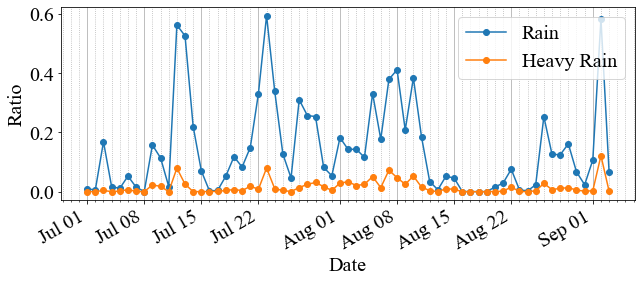

In [22]:
figure = mpl.figure.Figure(figsize=(9, 4))
ax1 = figure.subplots()

color = "tab:blue"
ax1.plot(stats_by_date_20.rain_ratio, label="Rain", marker="o")
ax1.plot(stats_by_date_20.heavy_ratio, label="Heavy Rain", marker="o")
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.xaxis.set_minor_locator(AutoMinorLocator(7))

ax1.legend()

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("precipitation_ratio_by_date_2020.pdf")
figure

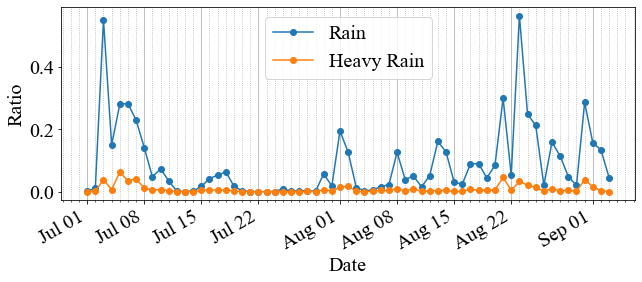

In [23]:
figure = mpl.figure.Figure(figsize=(9, 4))
ax1 = figure.subplots()

color = "tab:blue"
ax1.plot(stats_by_date_21.rain_ratio, label="Rain", marker="o")
ax1.plot(stats_by_date_21.heavy_ratio, label="Heavy Rain", marker="o")
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.xaxis.set_minor_locator(AutoMinorLocator(7))

ax1.legend()

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("precipitation_ratio_by_date_2021.pdf")
figure

### Stats by Hour

In [24]:
stats_by_hour = stats_by_time.groupby("hour").aggregate("sum")
stats_by_hour = get_ratios(stats_by_hour)
stats_by_hour_20 = stats_by_time[stats_by_time.date.dt.year==2020].groupby("hour").aggregate("sum")
stats_by_hour_20 = get_ratios(stats_by_hour_20)
stats_by_hour_21 = stats_by_time[stats_by_time.date.dt.year==2021].groupby("hour").aggregate("sum")
stats_by_hour_21 = get_ratios(stats_by_hour_21)

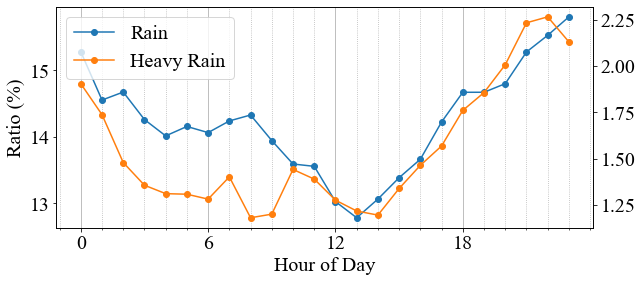

In [26]:
figure = mpl.figure.Figure(figsize=(9, 4))
ax1 = figure.subplots()

color = "tab:blue"
ln1 = ax1.plot(stats_by_hour_20.rain_ratio * 100, color=color, label="Rain", marker="o")
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Ratio (%)')
ax1.tick_params(axis='y')

color = "tab:orange"
ax2 = ax1.twinx()
ln2 = ax2.plot(stats_by_hour_20.heavy_ratio * 100, color=color, label="Heavy Rain", marker="o")
ax2.set_xlabel('Hour of Day')
 
ax2.set_xticks(stats_by_hour_21.index[::6])
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y')

minor_locator = AutoMinorLocator(6)
ax2.xaxis.set_minor_locator(minor_locator)

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# for label in ax1.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')
# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("precipitation_ratio_by_hour_2020.pdf")
figure

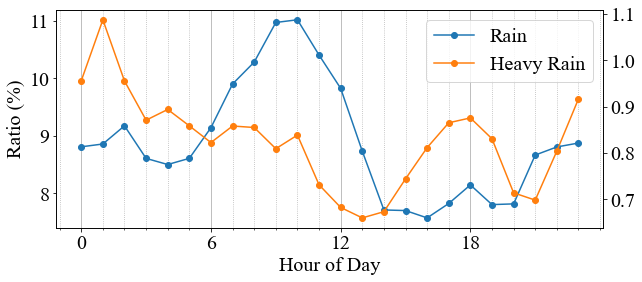

In [27]:
figure = mpl.figure.Figure(figsize=(9, 4))
ax1 = figure.subplots()

color = "tab:blue"
ln1 = ax1.plot(stats_by_hour_21.rain_ratio * 100, color=color, label="Rain", marker="o")
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Ratio (%)')
ax1.tick_params(axis='y')

color = "tab:orange"
ax2 = ax1.twinx()
ln2 = ax2.plot(stats_by_hour_21.heavy_ratio * 100, color=color, label="Heavy Rain", marker="o")
ax2.set_xlabel('Hour of Day')
 
ax2.set_xticks(stats_by_hour_21.index[::6])
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y')

minor_locator = AutoMinorLocator(6)
ax2.xaxis.set_minor_locator(minor_locator)

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# for label in ax1.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')
# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("precipitation_ratio_by_hour_2021.pdf")
figure

## Spacial

In [28]:
dfp = nc.Dataset("/data/nims/GDPS_KIM/202007/01/00/dfp.ft000.nc")
dfp_dict = {}
for k in dfp.variables.keys():
    dfp_dict[k] = dfp[k][:]
lon, lat = np.meshgrid(dfp_dict['lons'], dfp_dict['lats'])

def plot_on_map(featuremap, ax=None, vmin=None, vmax=None):
    # m = Basemap(width=1500000,height=1000000, resolution='l',projection='stere', lat_0=35.5, lon_0=128. )
    m = Basemap(width=900000,height=700000, resolution='l',projection='stere', lat_0=36, lon_0=128., ax=ax)
    xi, yi = m(lon, lat)

    cs = m.pcolor(xi ,yi, featuremap, ax=ax, vmin=vmin, vmax=vmax)

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 1.5), labels=[5,0,0,0], fontsize=16, ax=ax)
    m.drawmeridians(np.arange(-180., 181., 2), labels=[0,0,0,5], fontsize=16, ax=ax)
    
    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    
    return cs

/tmp/ipykernel_112924/1781430030.py:13: RuntimeWarning: invalid value encountered in true_divide
  point_rain_ratio = point_rain / point_valid
/tmp/ipykernel_112924/1781430030.py:14: RuntimeWarning: invalid value encountered in true_divide
  point_heavy_ratio = point_heavy / point_valid
/tmp/ipykernel_112924/1781430030.py:15: RuntimeWarning: invalid value encountered in true_divide
  point_no_rain_ratio = point_no_rain / point_valid
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = m.pcolor(xi ,yi, featuremap, ax=ax, vmin=vmin, vmax=vmax)
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3

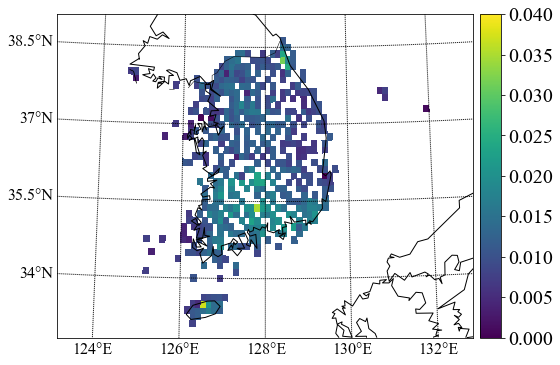

In [29]:
full_array = np.stack(arrays)

full_valid = ~np.isnan(full_array)
full_no_rain = (full_array < 0.1)
full_rain = (full_array >= 0.1) & (full_array < 10)
full_heavy = (full_array >= 10)

point_valid = full_valid.sum(axis=0)
point_no_rain = full_no_rain.sum(axis=0)
point_rain = full_rain.sum(axis=0)
point_heavy = full_heavy.sum(axis=0)

point_rain_ratio = point_rain / point_valid
point_heavy_ratio = point_heavy / point_valid
point_no_rain_ratio = point_no_rain / point_valid

for key, f in zip(["no_rain", "rain", "heavy"], [point_no_rain_ratio, point_rain_ratio, point_heavy_ratio]):
    figure = mpl.figure.Figure(figsize=(8, 5))
    ax = figure.subplots()
    if key == "no_rain":
        vmin, vmax = 0.65, 1
    elif key == "rain":
        vmin, vmax = 0, 0.3
    elif key == "heavy":
        vmin, vmax = 0, 0.04
    cs = plot_on_map(f, ax=ax, vmin=vmin, vmax=vmax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    figure.colorbar(cs, cax=cax)
    figure.tight_layout(pad=0.25)
    figure.savefig("spatial_{}_ratio.pdf".format(key))
figure

In [30]:
arrays20 = []
arrays21 = []
for ts, a in arrays_by_timestamp.items():
    if ts.year == 2020:
        arrays20.append(a)
    elif ts.year == 2021:
        arrays21.append(a)
    else:
        raise Exception()

### Only 2020

/tmp/ipykernel_112924/2606842523.py:11: RuntimeWarning: invalid value encountered in true_divide
  point_rain_ratio = point_rain / point_valid
/tmp/ipykernel_112924/2606842523.py:12: RuntimeWarning: invalid value encountered in true_divide
  point_heavy_ratio = point_heavy / point_valid
/tmp/ipykernel_112924/2606842523.py:13: RuntimeWarning: invalid value encountered in true_divide
  point_no_rain_ratio = point_no_rain / point_valid
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = m.pcolor(xi ,yi, featuremap, ax=ax, vmin=vmin, vmax=vmax)
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3

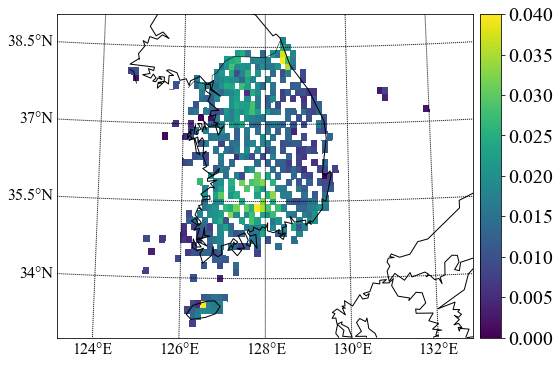

In [31]:
full_array = np.stack(arrays20)

full_valid = ~np.isnan(full_array)
full_no_rain = (full_array < 0.1)
full_rain = (full_array >= 0.1) & (full_array < 10)
full_heavy = (full_array >= 10)
point_valid = full_valid.sum(axis=0)
point_no_rain = full_no_rain.sum(axis=0)
point_rain = full_rain.sum(axis=0)
point_heavy = full_heavy.sum(axis=0)
point_rain_ratio = point_rain / point_valid
point_heavy_ratio = point_heavy / point_valid
point_no_rain_ratio = point_no_rain / point_valid

for key, f in zip(["no_rain", "rain", "heavy"], [point_no_rain_ratio, point_rain_ratio, point_heavy_ratio]):
    figure = mpl.figure.Figure(figsize=(8, 5))
    ax = figure.subplots()
    if key == "no_rain":
        vmin, vmax = 0.65, 1
    elif key == "rain":
        vmin, vmax = 0, 0.3
    elif key == "heavy":
        vmin, vmax = 0, 0.04
    cs = plot_on_map(f, ax=ax, vmin=vmin, vmax=vmax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    figure.colorbar(cs, cax=cax)
    figure.tight_layout(pad=0.25)
    figure.savefig("spatial_{}_ratio_2020.pdf".format(key))
figure

### Only 2021

/tmp/ipykernel_112924/2835811573.py:11: RuntimeWarning: invalid value encountered in true_divide
  point_rain_ratio = point_rain / point_valid
/tmp/ipykernel_112924/2835811573.py:12: RuntimeWarning: invalid value encountered in true_divide
  point_heavy_ratio = point_heavy / point_valid
/tmp/ipykernel_112924/2835811573.py:13: RuntimeWarning: invalid value encountered in true_divide
  point_no_rain_ratio = point_no_rain / point_valid
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = m.pcolor(xi ,yi, featuremap, ax=ax, vmin=vmin, vmax=vmax)
/tmp/ipykernel_112924/91308100.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3

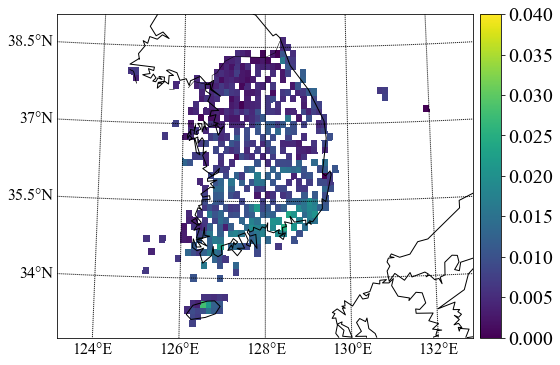

In [32]:
full_array = np.stack(arrays21)

full_valid = ~np.isnan(full_array)
full_no_rain = (full_array < 0.1)
full_rain = (full_array >= 0.1) & (full_array < 10)
full_heavy = (full_array >= 10)
point_valid = full_valid.sum(axis=0)
point_no_rain = full_no_rain.sum(axis=0)
point_rain = full_rain.sum(axis=0)
point_heavy = full_heavy.sum(axis=0)
point_rain_ratio = point_rain / point_valid
point_heavy_ratio = point_heavy / point_valid
point_no_rain_ratio = point_no_rain / point_valid

for key, f in zip(["no_rain", "rain", "heavy"], [point_no_rain_ratio, point_rain_ratio, point_heavy_ratio]):
    figure = mpl.figure.Figure(figsize=(8, 5))
    ax = figure.subplots()
    if key == "no_rain":
        vmin, vmax = 0.65, 1
    elif key == "rain":
        vmin, vmax = 0, 0.3
    elif key == "heavy":
        vmin, vmax = 0, 0.04
    cs = plot_on_map(f, ax=ax, vmin=vmin, vmax=vmax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    figure.colorbar(cs, cax=cax)
    figure.tight_layout(pad=0.25)
    figure.savefig("spatial_{}_ratio_2021.pdf".format(key))
figure